In [256]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

# Non-Uniform Rational B-Splines (NURBS)
*In an exploration of the possibilities of Jupyter Notebooks, I like to consider NURBS. These curves (or surfaces or solids) play a basic but important role for my graduation thesis. My goal is to make extensive use of numpy and its vectorization capabilities.*

NURBS are formed as a combination of basis functions, each defined by the Cox-De Boor recursion formula[\[1\]](#References)[\[2\]](#References).

$$ N_{i,n}\left(\xi\right) =\frac{\xi-k_i}{k_{i+n}-k_i}N_{i,n-1}\left(\xi\right) +\frac{k_{i+n+1}-\xi}{k_{i+n+1}-k_{i+1}}N_{i+1,n-1}\left(\xi\right) $$

This formula yields the $i$th basis function of polynomial order $p$, given a knot vector $k$. An implementation for `array`s of $\xi$ values is suitable for plotting purposes.

In [148]:
# Cox-De Boor recursion formula, result evaluated for array xi
# i = 0, 1, 2, ..., n
def cox_de_boor(knots, i, p, xi):
    if p == 0:
        isbetween = np.logical_and(xi >= knots[i], xi < knots[i + 1])
        return np.where(isbetween, 1, 0)
    
    result = np.zeros_like(xi)
    
    # determine if denominators are zero first
    Ad = knots[i + p] - knots[i]
    if Ad != 0:
        A = xi - knots[i] / Ad
        result += A * cox_de_boor(knots, i, p - 1, xi)

    Bd = knots[i + p + 1] - knots[i + 1]
    if Bd != 0:
        B = knots[i + p + 1] - xi / Bd
        result += B * cox_de_boor(knots, i + 1, p - 1, xi)
    
    return result

Constructing NURBS requires taking a sum of the basis functions belonging to a certain polynomial order. It is therefore often convenient to collect values of all basis functions for all $\xi$ positions in a 2D matrix.

In [316]:
def basis_matrix(knots, xi):
    # determine polynomial order from assumed open knot vector
    p = np.sum(knots == knots[0]) - 1
    
    # number of basis functions
    n = knots.size - p - 1
    
    result = np.empty((n, xi.size))
    for i in range(n):
        result[i, :] = cox_de_boor(knots, i, p, xi)
    
    return result

Plotting a NURBS basis then becomes straightforward.

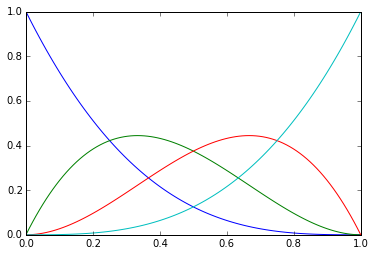

In [317]:
knots = np.array([0., 0., 0., 0., 1., 1., 1., 1.])
xi = np.linspace(knots[0], 0.99999 * knots[-1], 100)

basis = basis_matrix(knots, xi)

plt.plot(np.tile(xi, (p + 1, 1)).T, basis.T)
plt.show()

The actual NURBS is formed as a linear combination of the basis. In a way, each basis value is 'weighted' and combined with a control point.[\[1\]](#References)

$$ C\left(\xi\right) =\sum\limits^k_{i=1}\frac{N_{i,n}\left(\xi\right) w_i}{\sum^k_{j=1}N_{j,n}\left(\xi\right) w_j} $$

In [318]:
class NURBS(object):
    def __init__(self, knots, cpoints, weights):
        self.knots = knots
        self.cpoints = cpoints
        self.weights = weights
    
    def eval(self, xi):
        basis = basis_matrix(self.knots, xi)
        
        wbasis = np.einsum('i, ij -> ij', self.weights, basis)
        W = wbasis.sum(axis=0)
        
        return np.einsum('ij, ik -> jk', self.cpoints, wbasis / W)

Note the use of the `einsum()` function.[\[3\]](#References) While this method may require some work to understand, the author believes it provides the computation with more transparency than conventional matrix manipulation.

This `NURBS` object may then be used to plot a curve in space. A spiral for instance, is readily constructed.

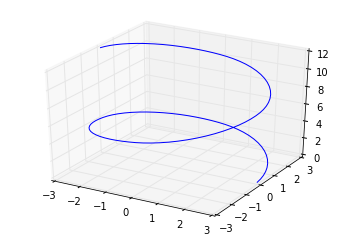

In [319]:
knots = np.array([0., 0., 0., 1., 1., 2., 2., 3., 3., 4., 4., 5., 5., 6., 6., 6.])
cpoints = np.array([[3, 0, 0], [3, 3, 1], [0, 3, 2], [-3, 3, 3],
                   [-3, 0, 4], [-3, -3, 5], [0, -3, 6], [3, -3, 7],
                   [3, 0, 8], [3, 3, 9], [0, 3, 10], [-3, 3, 11],
                   [-3, 0, 12]])
w = 1 / np.sqrt(2)
weights = np.array([1, w, 1, w, 1, w, 1, w, 1, w, 1, w, 1])

curve = NURBS(knots, cpoints, weights)

xi = np.linspace(knots[0], 0.99999 * knots[-1], 100)
x, y, z = curve.eval(xi)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(x, y, z)
plt.show()

NURBS may be expanded to higher dimensional objects[\[1\]](#References). The basis is then a 'tensor product' of one dimensional basis functions. For this reason, NURBS surfaces (and solids) are said to have a 'tensor product structure'. As an example, a NURBS surface is computed.

$$ S\left(\xi,\eta\right) =\sum\limits^k_{i=1}\sum\limits^l_{j=1}\frac{N_{i,n}\left(\xi\right) N_{j,m}\left(\eta\right) w_{i,j}}{\sum^k_{p=1}\sum^l_{q=1}N_{p,n}\left(\xi\right) N_{q,m}\left(\eta\right) w_{p,q}} $$

In [305]:
class Surface(object):
    def __init__(self, knots_xi, knots_eta, cpoints, weights):
        self.knots_xi = knots_xi
        self.knots_eta = knots_eta
        self.cpoints = cpoints
        self.weights = weights
    
    def eval(self, xi, eta):
        basis_xi = basis_matrix(knots_xi, xi)
        basis_eta = basis_matrix(knots_eta, eta)
        
        wbasis = np.einsum('ij, ik, jl -> ijkl', self.weights, basis_xi, basis_eta)
        W = wbasis.sum(axis=(0, 1))
        
        return np.einsum('ijk, ijlm -> klm', self.cpoints, wbasis / W)

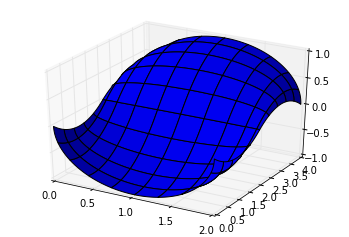

In [329]:
knots_xi = np.array([0., 0., 0., 1., 1., 2., 2., 2.])
knots_eta = knots_xi

cpoints = np.array([
        [[0, 0, 0]   , [0, 0, -1], [1, 0, -1], [2, 0, -1], [2, 0, 0]],
        [[0, 1, -0.5], [0, 1, -1], [1, 1, -1], [2, 1, -1], [2, 1, -0.5]],
        [[0, 2, 0]   , [0, 2, 0] , [1, 2, 0] , [2, 2, 0] , [2, 2, 0]],
        [[0, 3, 0.5] , [0, 3, 1] , [1, 3, 1] , [2, 3, 1] , [2, 3, 0.5]],
        [[0, 4, 0]   , [0, 4, 1] , [1, 4, 1] , [2, 4, 1] , [2, 4, 0]],
    ])
w = 1 / np.sqrt(2)
weights = np.array([
        [1, w, 1, w, 1],
        [1, w, 1, w, 1],
        [1, w, 1, w, 1],
        [1, w, 1, w, 1],
        [1, w, 1, w, 1],
    ])

surface = Surface(knots_xi, knots_eta, cpoints, weights)

xi = np.linspace(knots_xi[0], 0.99999 * knots_xi[-1], 100)
eta = np.linspace(knots_eta[0], 0.99999 * knots_eta[-1], 100)
x, y, z = surface.eval(xi, eta)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(x, y, z)
plt.show()

## References
* [1] [Wikipedia, Non-uniform rational B-spline, Technical specifications](https://en.wikipedia.org/wiki/Non-uniform_rational_B-spline#Technical_specifications)
* [2] [Wikipedia, De Boor's algorithm](https://en.wikipedia.org/wiki/De_Boor%27s_algorithm)
* [3] [Numpy's `einsum()`](http://docs.scipy.org/doc/numpy/reference/generated/numpy.einsum.html)

In [330]:
from IPython.core.display import HTML
HTML(open("style.css", "r").read())